In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import random
import os
import torch
import torchvision
import torchvision.transforms as transforms
import time

from torchvision import models
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install timm
import timm

     |████████████████████████████████| 431 kB 5.4 MB/s 


In [4]:
!pip install xmltodict
import xmltodict

**Load Dataset** 

Images are png files, annotations are xml files. 

In [5]:
proj_path = "/content/drive/MyDrive/COM_S_573_Project"
img_path = proj_path + "/data/images/"
xml_path = proj_path + "/data/annotations/"
imgs = sorted([f for f in os.listdir(img_path)])
xmls = sorted([f for f in os.listdir(xml_path)])

Final all the labels from xml files: "without_mask", "with_mask", "mask_weared_incorrect"

In [6]:
listing = []
for f in xmls:
  fd = open(xml_path + f)
  doc = xmltodict.parse(fd.read())
  obj = doc["annotation"]["object"]
  if type(obj) == list:
    for i in range(len(obj)):
      listing.append(obj[i]["name"])
  else:
    listing.append(obj["name"])

mask_labels = list(Counter(listing).keys())
mask_values = list(Counter(listing).values())

print("Labels:", mask_labels)
print("Number of each labels:", mask_values)


Labels: ['without_mask', 'with_mask', 'mask_weared_incorrect']
Number of each labels: [717, 3232, 123]


In [7]:
class FaceMaskDataset(Dataset):
  def __init__(self, imgs, xmls, img_dir, xml_dir, transform):
    self.images_tensor = []
    self.labels_tensor = []
    for idx in range(len(imgs)):
      img = imgs[idx]
      xml = xmls[idx]
      image = Image.open(img_dir + img).convert("RGB")

      # read annoations
      fd = open(xml_dir + xml)
      doc = xmltodict.parse(fd.read())
      obj = doc["annotation"]["object"]
      if type(obj) == list:
        for i in range(len(obj)):
          xmin, ymin, xmax, ymax = list(map(int, obj[i]["bndbox"].values()))
          img = transforms.functional.crop(image, ymin, xmin, ymax-ymin, xmax-xmin)
          self.images_tensor.append(transform(img))
          lab = mask_labels.index(obj[i]["name"])
          self.labels_tensor.append(torch.tensor(lab))
      else:
        xmin, ymin, xmax, ymax = list(map(int, obj["bndbox"].values()))
        img = transforms.functional.crop(image, ymin, xmin, ymax-ymin, xmax-xmin)
        self.images_tensor.append(transform(img))
        lab = mask_labels.index(obj["name"])
        self.labels_tensor.append(torch.tensor(lab))

  def __getitem__(self, idx):
    return self.images_tensor[idx], self.labels_tensor[idx]
  
  def __len__(self):
    return len(self.labels_tensor)

Load dataset with dataset loader and split dataset to training data and test data.

In [8]:
transform = transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomRotation(degrees=10), transforms.ToTensor()]) # data augmentation

mask_dataset = FaceMaskDataset(imgs, xmls, img_path, xml_path, transform)

train_indices, test_indices = train_test_split(list(range(len(mask_dataset.labels_tensor))), test_size=0.2, stratify=mask_dataset.labels_tensor) # stratify split

train_set = torch.utils.data.Subset(mask_dataset, train_indices)
test_set = torch.utils.data.Subset(mask_dataset, test_indices)

mask_train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
mask_test_loader = DataLoader(test_set, batch_size=32, shuffle=True, num_workers=2)

**Build Model**

Get GPU device for training

In [10]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda:0 device


Setup models and parameters. We use ResNet34.

In [11]:
resnet = models.resnet34(pretrained=True)

# disable training for last layer
for param in resnet.parameters():
    param.requires_grad = False

n_inputs = resnet.fc.in_features
output_layer = torch.nn.Linear(n_inputs, 3)
resnet.fc.out_features = output_layer

resnet = resnet.to(device)

resnet

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# open layers to be trained
for param in resnet.parameters():
  param.requires_grad = True

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

In [13]:
# model parameters
resnet_total_params = sum(p.numel() for p in resnet.parameters() if p.requires_grad)
print("Total parameters: ", resnet_total_params)

Total parameters:  21799211


**Train Model**

In [14]:
def train(epoch):
  global train_loss
  global train_acc
  global train_time
  
  running_loss = []
  total = 0
  correct = 0
  start = time.time()

  resnet.train()
  for batch, (images, labels) in enumerate(mask_train_loader):
    if torch.cuda.is_available():
          images, labels = images.cuda(), labels.cuda()
    
    optimizer.zero_grad()
    outputs = resnet(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss.append(loss.item())
    # train acc
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

  end = time.time()
  train_loss.append(np.mean(running_loss))
  train_acc.append(correct/total)
  train_time.append(end-start)
  print("training loss %.4f training accuracy %.4f time %.1fs" % (np.mean(running_loss), correct/total, end-start))

**Test**

In [15]:
def test():
  global y_true
  global y_pred

  running_loss = []
  total = 0
  correct = 0

  resnet.eval()
  with torch.no_grad():
    for images, labels in mask_test_loader:
      if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()

      outputs = resnet(images)
      loss = criterion(outputs, labels)
      running_loss.append(loss.item())
      # test acc
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
      y_true.extend(labels.cpu().detach().tolist())
      y_pred.extend(predicted.cpu().detach().tolist())
    
  print("Final testing loss %.4f testing accuracy %.4f" % (np.mean(running_loss), correct/total))  

Train 20 epochs.

In [16]:
num_epochs = 20
train_loss = []
train_acc = []
train_time = []
y_true = []
y_pred = []

for epoch in range(num_epochs):
  print("Epoch...%d/%d" % (epoch+1, num_epochs))
  train(epoch)

test()

Epoch...1/20
training loss 0.9244 training accuracy 0.8671 time 37.2s
Epoch...2/20
training loss 0.1067 training accuracy 0.9678 time 36.8s
Epoch...3/20
training loss 0.0365 training accuracy 0.9868 time 36.7s
Epoch...4/20
training loss 0.0195 training accuracy 0.9942 time 36.7s
Epoch...5/20
training loss 0.0139 training accuracy 0.9954 time 36.7s
Epoch...6/20
training loss 0.0062 training accuracy 0.9988 time 36.7s
Epoch...7/20
training loss 0.0064 training accuracy 0.9985 time 36.7s
Epoch...8/20
training loss 0.0054 training accuracy 0.9988 time 36.7s
Epoch...9/20
training loss 0.0054 training accuracy 0.9988 time 36.7s
Epoch...10/20
training loss 0.0034 training accuracy 0.9994 time 36.7s
Epoch...11/20
training loss 0.0040 training accuracy 0.9991 time 36.6s
Epoch...12/20
training loss 0.0028 training accuracy 0.9997 time 36.5s
Epoch...13/20
training loss 0.0024 training accuracy 0.9997 time 36.5s
Epoch...14/20
training loss 0.0013 training accuracy 1.0000 time 36.6s
Epoch...15/20
t

Save training process.

In [17]:
epochs = list(range(1, num_epochs+1))

dict = {"epoch": epochs, "train_loss": train_loss, "train_acc": train_acc, "train_time": train_time}
df = pd.DataFrame(dict)
df.to_csv(proj_path + "/models/resnet_train.csv")

Show evaulation matrix.

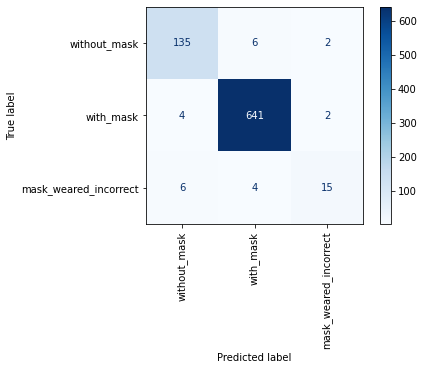

In [18]:
disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=mask_labels, cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.savefig(proj_path + "/images/resnet_cm.png", dpi=400, bbox_inches='tight')
plt.show()

In [19]:
cr = classification_report(y_true, y_pred, target_names=mask_labels)
print(cr)

                       precision    recall  f1-score   support

         without_mask       0.93      0.94      0.94       143
            with_mask       0.98      0.99      0.99       647
mask_weared_incorrect       0.79      0.60      0.68        25

             accuracy                           0.97       815
            macro avg       0.90      0.84      0.87       815
         weighted avg       0.97      0.97      0.97       815

